In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
     ('order_items.csv', 'order_items'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='ARINSAHNI',
    database='ECOMMERCE '
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/arinsahni/Desktop/SQL PROJECT /E Commerce '

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close() 

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state            

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 


In [3]:

# One-time database connection setup
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='ARINSAHNI',
    database='ECOMMERCE'
)

# One-time cursor setup
cur = conn.cursor()
query = " select distinct customer_city from customers"

cur.execute(query) 
data = cur.fetchall()
df = pd.DataFrame(data )

df.head 

<bound method NDFrame.head of                           0
0                    franca
1     sao bernardo do campo
2                 sao paulo
3           mogi das cruzes
4                  campinas
...                     ...
4114                 siriji
4115    natividade da serra
4116           monte bonito
4117             sao rafael
4118      eugenio de castro

[4119 rows x 1 columns]>

# count the number of ordered placed in 2017 

In [4]:
# order_status 
query = " select count(order_id) from orders where year (order_purchase_timestamp) = 2017   "

cur.execute(query) 
data = cur.fetchall()

" total number of order placed are " , data[0][0] 

(' total number of order placed are ', 90202)

# FIND TOTAL SALES PER CATEGORY

In [5]:
query = """ select upper(products.product_category) category , 
round(sum(payments.payment_value)) sales 
from products join order_items
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id 
group by category """ 
cur.execute(query) 
data = cur.fetchall()
df = pd.DataFrame (data , columns = ["category" , "amount" ] ) 
df 

,category,amount
0,PERFUMERY,4053909.0
1,FURNITURE DECORATION,11441411.0
2,TELEPHONY,3895056.0
3,BED TABLE BATH,13700429.0
4,AUTOMOTIVE,6818355.0
...,...,...
69,CDS MUSIC DVDS,9595.0
70,LA CUISINE,23308.0
71,FASHION CHILDREN'S CLOTHING,6285.0
72,PC GAMER,17395.0


# Calculate the percentage  of order that were payed in installements 

In [6]:
query = """ select (sum(case when payment_installments >= 2 then 1 else 0 end)) / count(*)*100 from payments  """ 
cur.execute(query) 
data = cur.fetchall()
data 


[(Decimal('49.4200'),)]

# Count number of customer in each state 

<function matplotlib.pyplot.show(close=None, block=None)>

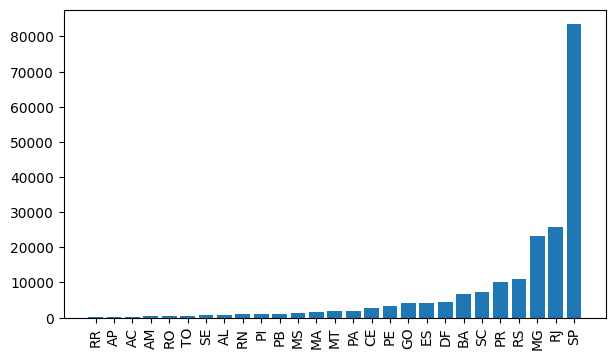

In [7]:
query = """ select customers.customer_state , count(customers.customer_id)  count 
from customers 
group by customer_state """ 
cur.execute(query) 
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["state" , "count" ] ) 
df = df.sort_values( by = "count" , ascending= True ) 
df 
plt.figure(figsize = (7,4) ) 
plt.bar (df ["state"] , df["count"]) 
plt.xticks ( rotation = 90 ) 
plt.show 

# calculate the number of orders per month in 2018  


<function matplotlib.pyplot.show(close=None, block=None)>

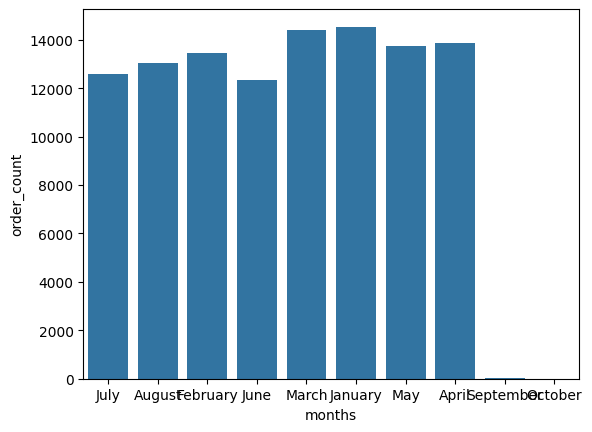

In [8]:
query = """
SELECT MONTHNAME(order_purchase_timestamp) AS months, 
       COUNT(order_id) AS order_count 
FROM orders 
WHERE YEAR(order_purchase_timestamp) = 2018 
GROUP BY months
""" 

cur.execute(query) 
data = cur.fetchall() 

df = pd.DataFrame(data , columns = ["months" , "order_count"])
order = ["january" , "february" , "march" , "april" , "may" ,
         "june" , "july" , "august", "september" ,"october" , 
         "november" ,"december"]
sns.barplot ( x = df["months"] , y = df["order_count"] , data = df  )
plt.show 

# FIND AVERAGE NUMBER OF PRODUCTS PER ORDER , GROUPED BY CUSTOMER CITY 

In [9]:
import mysql.connector
import pandas as pd
# One-time database connection setup
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='ARINSAHNI',
    database='ECOMMERCE'
)

# One-time cursor setup
cur = conn.cursor()


query = """
with count_per_order as 
  ( select orders.order_id , 
  orders.customer_id , 
  count(order_items.order_id) as oc 
from orders 
join order_items 
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id ) 
select customers.customer_city  , avg(count_per_order.oc) as average 
from customers 
join count_per_order
on customers.customer_id = count_per_order.customer_id 
group by customers.customer_city 
order by average desc  ;; 
""" 

cur.execute(query) 
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["CUSTOMER_CITY" , "AVERAGE_PRODUCT"]) 
df.head(10)

,CUSTOMER_CITY,AVERAGE_PRODUCT
0,padre carvalho,28.0000
1,celso ramos,26.0000
2,datas,24.0000
3,candido godoi,24.0000
4,matias olimpio,20.0000
5,cidelandia,16.0000
6,curralinho,16.0000
7,picarra,16.0000
8,morro de sao paulo,16.0000
9,teixeira soares,16.0000


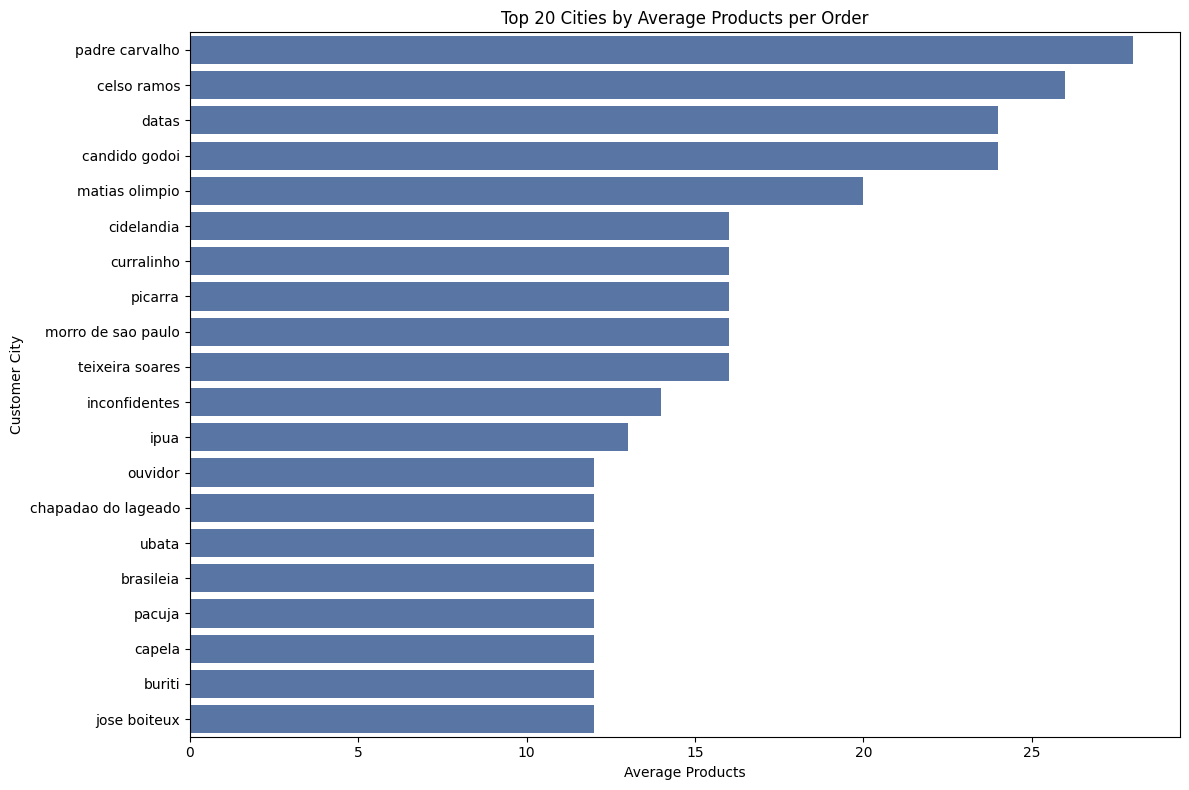

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("deep")
# Top 20 cities
top_20 = df.sort_values(by="AVERAGE_PRODUCT", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(y="CUSTOMER_CITY", x="AVERAGE_PRODUCT", data=top_20)
plt.title("Top 20 Cities by Average Products per Order")
plt.xlabel("Average Products")
plt.ylabel("Customer City")
plt.tight_layout()
plt.show()

# Calculate the percentage of total revenue contributed by each product category

In [11]:
query = """ select (products.product_category) as category , 
sum((payments.payment_value)/ (select sum(payment_value) from payments) )*100 
 as  sales_percent
from products join order_items
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id 
group by category  order by sales_percent desc 

""" 
cur.execute(query) 
data = cur.fetchall()
df = pd.DataFrame (data , columns = ["category" , "percentage_revenue" ] ) 
df.head(10)  

,category,percentage_revenue
0,bed table bath,42.790114
1,HEALTH BEAUTY,41.411365
2,computer accessories,39.611296
3,Furniture Decoration,35.734595
4,Watches present,35.710615
5,sport leisure,34.783901
6,housewares,27.353785
7,automotive,21.295550
8,Garden tools,20.945404
9,Cool Stuff,19.481647


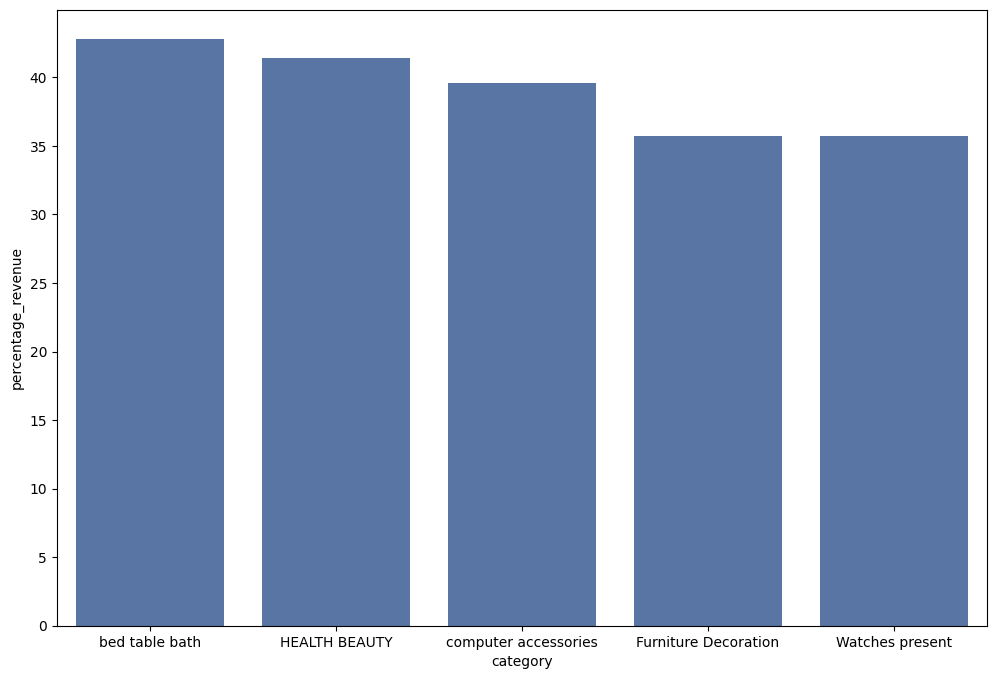

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(12, 8))
top_5 = df.sort_values( by= "percentage_revenue" , ascending= False ) .head(5) 
sns.barplot( x = "category" , y = "percentage_revenue" , data = top_5 ) 
  
plt.show() 

# Identify the correlation between product price and the number of times a product has beem purchased


In [13]:
import numpy as np 
query = """ select products.product_category, 
count(order_items.product_id) as times,
round(avg(order_items.price),2) as price 
from order_items join products 
on order_items.product_id = products.product_id
group by products.product_category order by times desc ;

""" 
cur.execute(query) 
data = cur.fetchall()
df = pd.DataFrame (data , columns = ["category" , "number_of_times_ordered" , "average_price" ] ) 
df

,category,number_of_times_ordered,average_price
0,bed table bath,44460,93.30
1,HEALTH BEAUTY,38680,130.16
2,sport leisure,34564,114.34
3,Furniture Decoration,33336,87.56
4,computer accessories,31308,116.51
...,...,...,...
69,La Cuisine,56,146.78
70,cds music dvds,56,52.14
71,PC Gamer,36,171.77
72,Fashion Children's Clothing,32,71.23


In [14]:
import numpy as np 
arr1 = df["number_of_times_ordered"]
arr2 = df["average_price"]

In [15]:
a = np.corrcoef([arr1,arr2]) 
print("correlation between product price and the number of times a product has beem purchased is" , a[0][1] ) 
      

correlation between product price and the number of times a product has beem purchased is -0.10631514167157564


#  Calculate the total revenue generated by each seller, and rank them by revenue.


In [16]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()


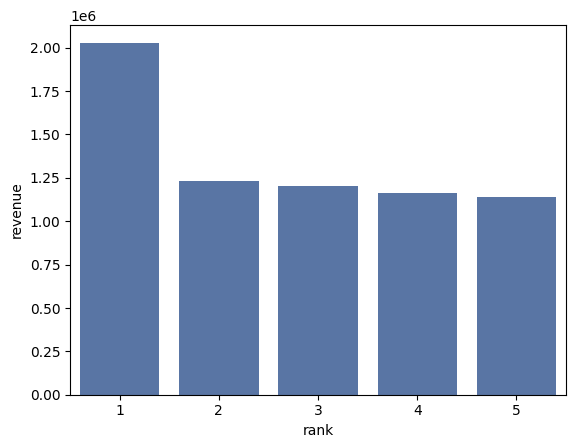

In [17]:
sns.barplot(x = "rank", y = "revenue", data = df)
plt.show()

# Calculate the moving average of order values for each customer over their order history.


In [18]:
 
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year. 

In [19]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# Calculate the year-over-year growth rate of total sales.

In [20]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [21]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

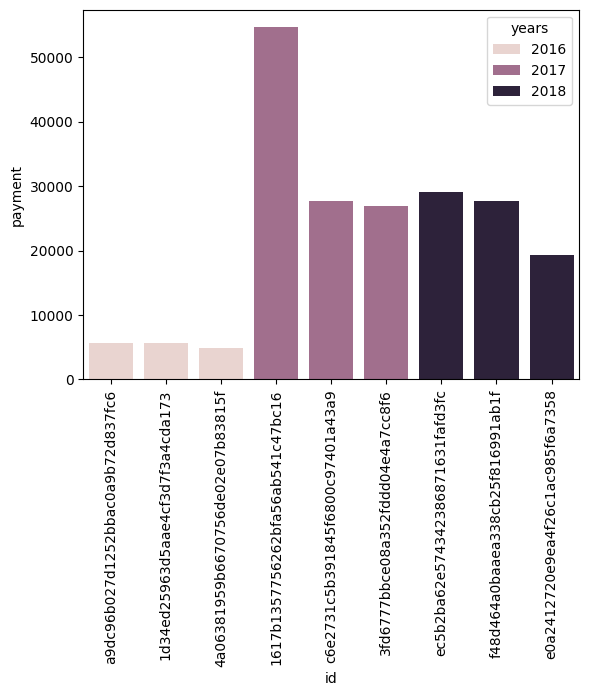

In [22]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()